In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
import catboost as cb
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
import pprint
from typing import *
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.preprocessing import TargetEncoder
from ktools.preprocessing.categorical_denoiser_prepreprocesser import CategoricalDenoiserPreprocessor
from ktools.metrics.fast_matthew_correlation_coefficient import fast_matthews_corr_coeff
from ktools.preprocessing.categorical_string_label_error_imputator import CategoricalLabelErrorImputator
from ktools.preprocessing.categorical_features_embedder import SortMainCategories
from ktools.preprocessing.kaggle_dataset_manager import KaggleDatasetManager
from ktools.utils.data_science_pipeline_settings import DataSciencePipelineSettings
from sklearn.linear_model import LogisticRegression
from ktools.fitting.cross_validate_then_test_sklearn_model import CrossValidateTestSklearnModel

/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_csv_path = "data/used_car_prices/train.csv"
test_csv_path = "data/used_car_prices/test.csv"
target_col_name = "price"

In [3]:
train_df = pd.read_csv(train_csv_path, index_col=0)
test_df = pd.read_csv(test_csv_path, index_col=0)

================================================== Exploring train/test shapes ==================================================
The shape of the train dataset is: (188533, 12)
The shape of the test dataset is: (125690, 11)
================================================== Percentage nans ==================================================
Train:  {'brand': 0.0, 'model': 0.0, 'model_year': 0.0, 'milage': 0.0, 'fuel_type': 2.696079731399808, 'engine': 0.0, 'transmission': 0.0, 'ext_col': 0.0, 'int_col': 0.0, 'accident': 1.3005680703112983, 'clean_title': 11.360875814844086, 'price': 0.0}
Test:  {'brand': 0.0, 'model': 0.0, 'model_year': 0.0, 'milage': 0.0, 'fuel_type': 2.69154268438221, 'engine': 0.0, 'transmission': 0.0, 'ext_col': 0.0, 'int_col': 0.0, 'accident': 1.2984326517622722, 'clean_title': 11.328665764977325}
================================================== Duplicated columns ==================================================
0
==============================================

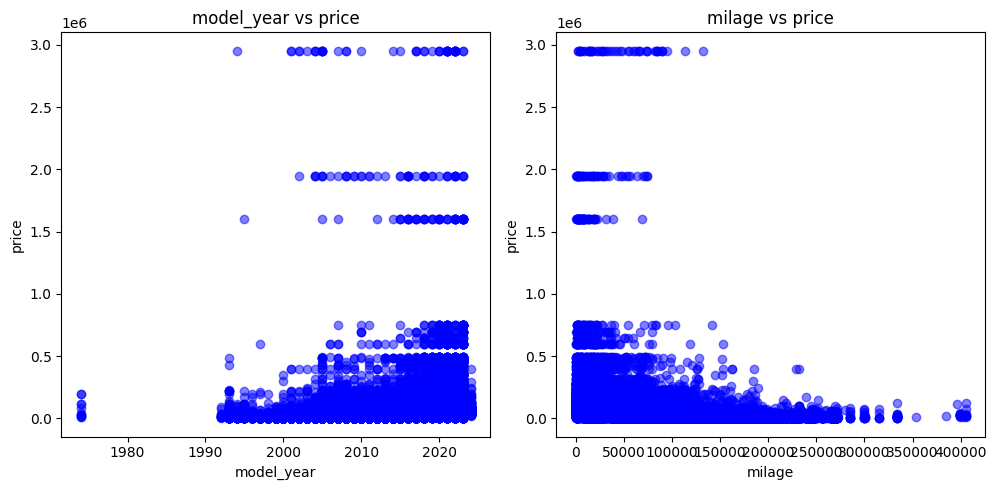

================================================== Categorical columns ==================================================


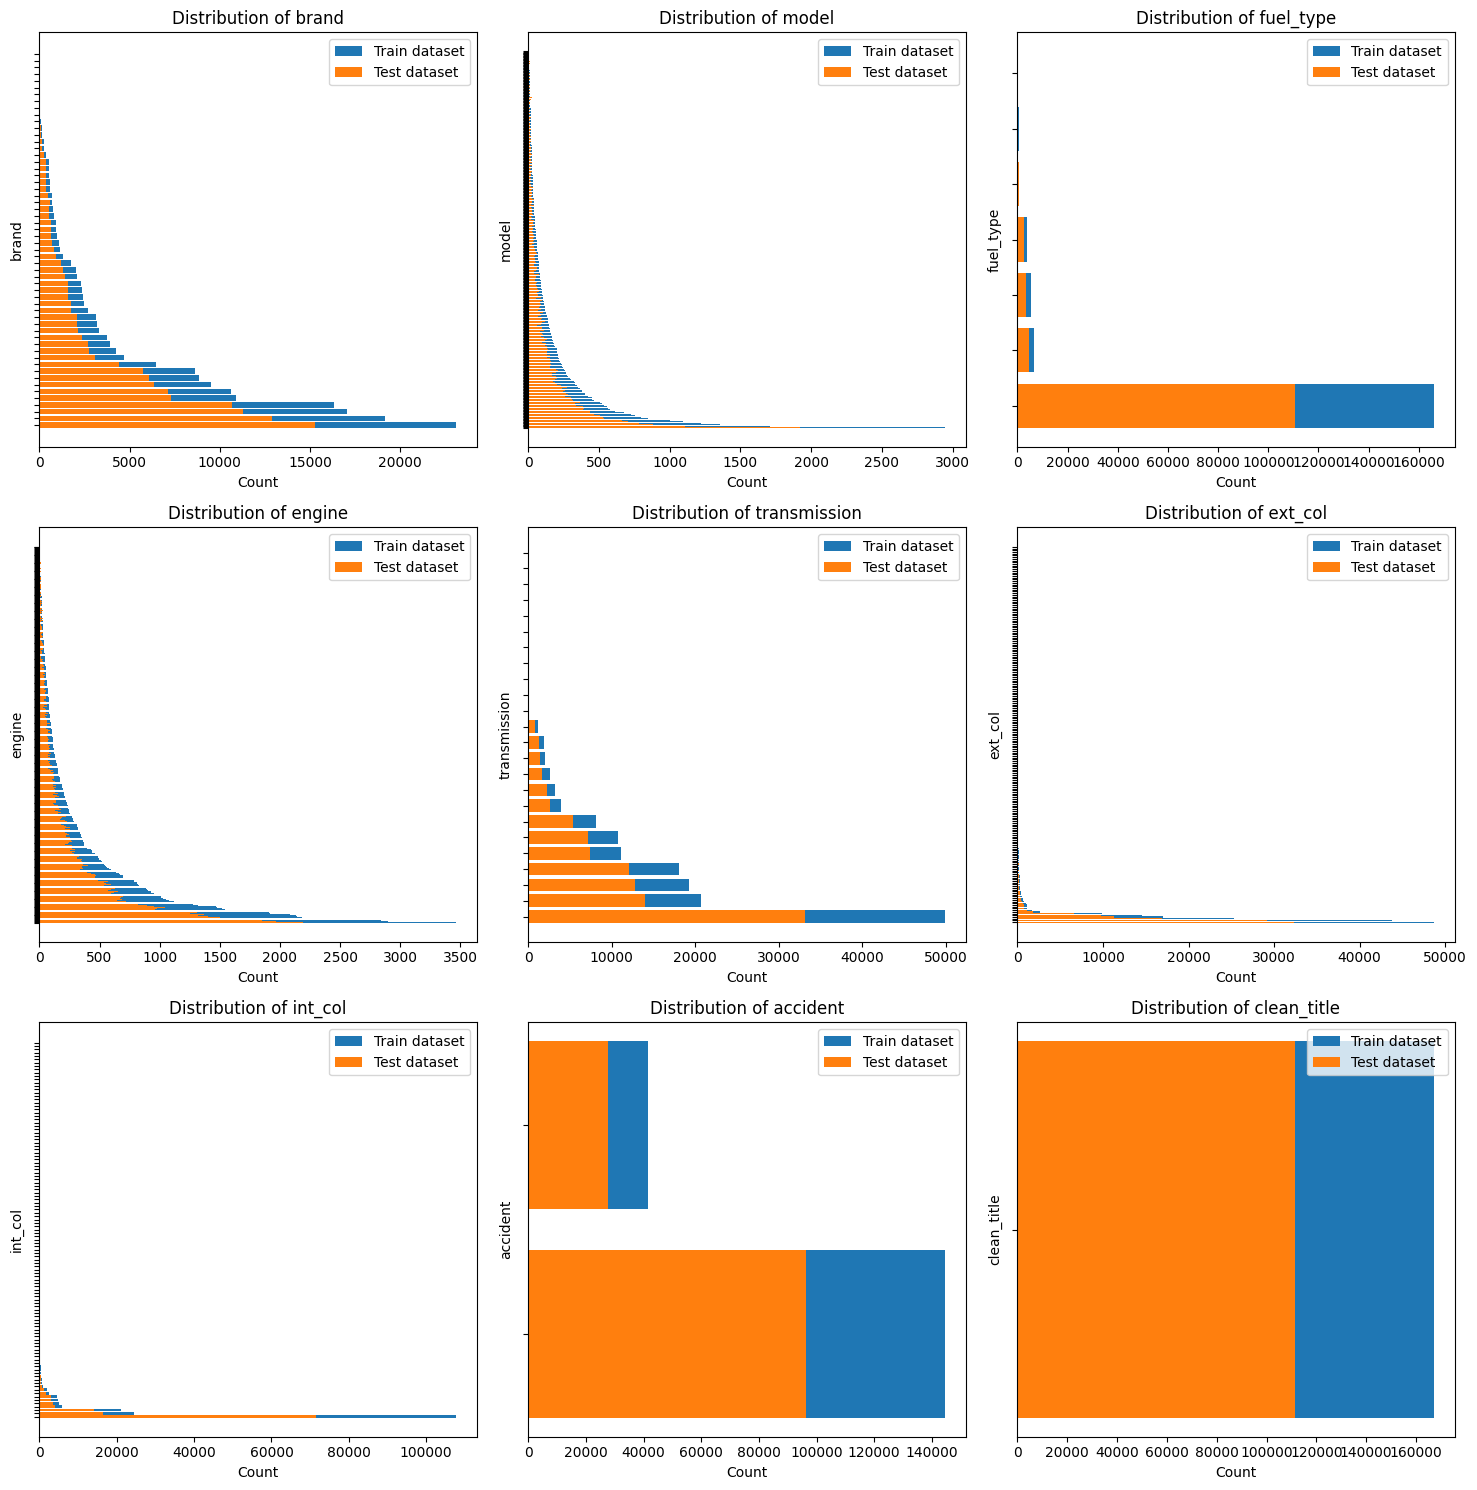

In [4]:
from ktools.visualization.basic_eda import BasicDatasetEDA


BasicDatasetEDA(train_df, test_df, target_col_name).review()

In [40]:
settings = DataSciencePipelineSettings(train_csv_path,
                                        test_csv_path,
                                        target_col_name)
encoded_df, encoded_test_df, new_settings = CategoricalDenoiserPreprocessor(settings,
                                                                            return_categorical=True,
                                                                            verbose=True).process()

The following columns are not consistent across data sets: set()
(original : new category) {'black onyx': 'black', 'rioja red': 'red', 'diesel gray / black': 'black', 'medium earth gray': 'gray', 'satin black': 'black', 'canberra beige/black': 'black', 'shara beige': 'beige', 'black/gun metal': 'black', 'canberra beige': 'beige', 'white / brown': 'brown', 'charcoal black': 'black', 'silk beige/espresso brown': 'beige', 'charles blue': 'blue', 'titan black / quarzit': 'black', 'black w/red stitching': 'black', 'ebony black': 'black', 'adrenaline red': 'red', 'black/saddle brown': 'black', 'grace white': 'white', 'ebony / pimento': 'ebony', 'pearl beige': 'beige', 'black / saddle': 'black', 'aragon brown': 'brown', 'pimento red w/ebony': 'red', 'pimento / ebony': 'ebony', 'ebony.': 'ebony', 'black / brown': 'black', 'ebony/light oyster stitch': 'ebony', 'red / black': 'black', 'black/red': 'black', 'sarder brown': 'brown', 'sakhir orange/black': 'black', 'tan/ebony': 'ebony', 'almond bei

In [41]:
encoded_df

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
id,,,,,,,,,,,,
0,27.0,43.000000,2007,213000,0.0,134.000000,0.0,11.0,2.0,0.0,0.0,46.669018
1,19.0,44.927514,2002,143250,0.0,47.416177,0.0,3.0,1.0,1.0,0.0,46.669018
2,3.0,44.927514,2002,136731,2.0,51.000000,0.0,4.0,2.0,0.0,0.0,46.669018
3,28.0,44.927514,2017,19500,0.0,47.416177,2.0,0.0,0.0,0.0,0.0,26.000000
4,1.0,55.000000,2021,7388,0.0,59.000000,6.0,0.0,1.0,0.0,0.0,46.669018
...,...,...,...,...,...,...,...,...,...,...,...,...
188528,10.0,48.000000,2017,49000,0.0,3.000000,2.0,1.0,1.0,0.0,0.0,25.000000
188529,1.0,44.927514,2018,28600,0.0,103.000000,1.0,1.0,0.0,1.0,0.0,2.000000
188530,1.0,44.927514,2021,13650,0.0,100.000000,6.0,1.0,0.0,0.0,0.0,46.669018


In [39]:
encoded_df

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
id,,,,,,,,,,,,
0,27,43,2007,213000,0,134,0,11,2,0,0,-1
1,19,-1,2002,143250,0,-1,0,3,1,1,0,-1
2,3,-1,2002,136731,2,51,0,4,2,0,0,-1
3,28,-1,2017,19500,0,-1,2,0,0,0,0,26
4,1,55,2021,7388,0,59,6,0,1,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
188528,10,48,2017,49000,0,3,2,1,1,0,0,25
188529,1,-1,2018,28600,0,103,1,1,0,1,0,2
188530,1,-1,2021,13650,0,100,6,1,0,0,0,-1


In [23]:
train_df = pd.read_csv(train_csv_path, index_col=0)

In [24]:
train_df.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

In [25]:
train_df.dtypes

brand           object
model           object
model_year       int64
milage           int64
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
clean_title     object
price            int64
dtype: object

In [26]:
train_df.shape

(188533, 12)

In [27]:
for col in train_df.columns:
    if train_df[col].dtype == "object":
        print("column name: ", col, train_df[col].value_counts().to_dict())
        train_df[col] = train_df[col].astype("category")

column name:  brand {'Ford': 23088, 'Mercedes-Benz': 19172, 'BMW': 17028, 'Chevrolet': 16335, 'Audi': 10887, 'Porsche': 10612, 'Land': 9525, 'Toyota': 8850, 'Lexus': 8643, 'Jeep': 6474, 'Cadillac': 4674, 'RAM': 4249, 'Nissan': 3930, 'Tesla': 3738, 'INFINITI': 3276, 'GMC': 3215, 'Dodge': 3133, 'Mazda': 2719, 'Kia': 2497, 'Lincoln': 2423, 'Subaru': 2381, 'Acura': 2282, 'Honda': 2101, 'Hyundai': 2045, 'Volkswagen': 1765, 'Jaguar': 1319, 'Bentley': 1155, 'MINI': 1064, 'Genesis': 969, 'Buick': 940, 'Maserati': 939, 'Lamborghini': 809, 'Chrysler': 727, 'Volvo': 723, 'Alfa': 682, 'Rivian': 590, 'Rolls-Royce': 561, 'Mitsubishi': 551, 'Pontiac': 538, 'Hummer': 520, 'Ferrari': 359, 'McLaren': 243, 'Aston': 238, 'Saturn': 148, 'Scion': 120, 'Lucid': 69, 'Mercury': 57, 'Lotus': 52, 'FIAT': 44, 'Saab': 22, 'Karma': 17, 'Suzuki': 8, 'Plymouth': 7, 'Bugatti': 7, 'Polestar': 7, 'smart': 3, 'Maybach': 3}
column name:  model {'F-150 XLT': 2945, 'M3 Base': 2229, 'Camaro 2SS': 1709, 'M4 Base': 1622, 'Must

In [28]:
train_df.dtypes

brand           category
model           category
model_year         int64
milage             int64
fuel_type       category
engine          category
transmission    category
ext_col         category
int_col         category
accident        category
clean_title     category
price              int64
dtype: object

In [29]:
train_df.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

In [30]:
training_col_names = ['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
target = "price"
data_manager = KaggleDatasetManager(train_df,
                                    training_col_names,
                                    target,
                                    0.8,
                                    0.2,
                                    0)

(X_train, 
X_valid, 
X_test, 
y_train, 
y_valid, 
y_test) = data_manager.dataset_partition()

In [35]:
from sklearn.metrics import r2_score,  root_mean_squared_error
from sklearn.model_selection import KFold


model = XGBRegressor(**{}, 
                        verbosity=0,
                        eval_metric='logloss',
                        tree_method='hist',
                        enable_categorical=True)
num_splits = 5
eval_metrics = {"r2" : r2_score, "rmse" : root_mean_squared_error}
skf = KFold(n_splits=num_splits)


model, cv_scores, test_scores = CrossValidateTestSklearnModel(model,
                              eval_metrics,
                              None,
                              num_splits).evaluate(X_train,
                                                   y_train,
                                                   X_test,
                                                   y_test)

Final Model r2: 0.007537
5-fold cross validation r2:  0.0
Final Model rmse: 74291.442122
5-fold cross validation rmse:  0.0


In [ ]:
from sklearn.linear_model import LinearRegression


LinearRegression

In [59]:
xgb_params = {'max_depth': 34, 
            'learning_rate': 0.009195574997217204, 
            'gamma': 0.947452139226582, 
            'subsample': 0.7048675112537893, 
            'colsample_bytree': 0.36816717431780044, 
            'lambda': 0.003497277552749157, 
            'alpha': 1.8894975902136887e-08, 
            'max_leaves': 478,
            'n_estimators' : 500}

In [3]:
# df = pd.read_csv("data/poisonous_mushrooms/train_updated.csv", index_col="id")
# test_df = pd.read_csv("data/poisonous_mushrooms/test_updated.csv", index_col="id")

In [46]:
train_csv_path = "data/poisonous_mushrooms/train.csv"
test_csv_path = "data/poisonous_mushrooms/test.csv"
target_col_name = "class"
settings = DataSciencePipelineSettings(train_csv_path,
                                        test_csv_path,
                                        target_col_name,
                                        )
encoded_df, encoded_test_df, new_settings = CategoricalDenoiserPreprocessor(settings,
                                                                            return_categorical=True).process()

In [26]:
def add_new_features(df):
    epsilon = 1e-6
    df['cap-stem-width'] = df['cap-diameter'] / (df['stem-width'] + epsilon)
    df['stem-width-to-height-ratio'] = df['stem-width'] / (df['stem-height'] + epsilon)
    df['stem-wider-than-height'] = (df['stem-width'] >= df['stem-height']).astype("category")
    df['cap-wider-than-stem'] = (df['cap-diameter'] >= df['stem-width']).astype("category")
    return df

In [27]:
encoded_exfeats_df = add_new_features(encoded_df.copy())
encoded_test_exfeats_df = add_new_features(encoded_test_df.copy())

In [28]:
encoded_exfeats_df

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,veil-color,has-ring,ring-type,spore-print-color,habitat,season,cap-stem-width,stem-width-to-height-ratio,stem-wider-than-height,cap-wider-than-stem
id,,,,,,,,,,,,,,,,,,,,,
0,1,8.80,1,1,8,0,0,0,0,4.51,...,-1,0,0,-1,0,0,0.571800,3.412416,True,False
1,0,4.51,0,3,5,0,0,0,1,4.79,...,-1,1,2,-1,0,2,0.695988,1.352818,True,False
2,1,6.94,1,1,9,0,2,0,0,6.85,...,-1,0,0,-1,2,2,0.698892,1.449635,True,False
3,1,3.88,1,2,3,0,4,-1,4,4.16,...,-1,0,0,-1,0,1,0.594181,1.569711,True,False
4,1,5.85,0,10,2,0,1,-1,0,3.37,...,-1,0,0,-1,1,0,0.699761,2.480711,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116940,1,9.29,1,-1,0,1,-1,-1,0,12.14,...,0,1,6,-1,0,1,0.493886,1.549423,True,False
3116941,1,10.88,2,-1,2,1,1,0,3,6.65,...,-1,0,0,-1,0,1,0.403411,4.055638,True,False
3116942,0,7.82,0,7,4,0,0,-1,0,9.51,...,0,1,2,-1,0,0,0.707052,1.162986,True,False


In [32]:
encoded_df.columns

Index(['class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object')

In [67]:
extra_feature_cols = ['cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season', 'cap-stem-width', 'stem-width-to-height-ratio']
X_cols = ['cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season']
y_cols = ["class"]

In [68]:
data_manager_categorical = KaggleDatasetManager(encoded_df,
                                    X_cols,
                                    y_cols[0],
                                    0.8,
                                    0.2,
                                    0)

(X_train_categorical, 
X_valid_categorical, 
X_test_categorical, 
y_train_categorical, 
y_valid_categorical, 
y_test_categorical) = data_manager_categorical.dataset_partition()

In [69]:
data_manager_categorical_extra = KaggleDatasetManager(encoded_exfeats_df,
                                    extra_feature_cols,
                                    y_cols[0],
                                    0.8,
                                    0.2,
                                    0)

(X_train_categorical_extra, 
X_valid_categorical_extra, 
X_test_categorical_extra, 
y_train_categorical_extra, 
y_valid_categorical_extra, 
y_test_categorical_extra) = data_manager_categorical_extra.dataset_partition()

In [80]:
xgb_params = {'max_depth': 34, 
            'learning_rate': 0.009195574997217204, 
            'gamma': 0.947452139226582, 
            'subsample': 0.7048675112537893, 
            'colsample_bytree': 0.36816717431780044, 
            'lambda': 0.003497277552749157, 
            'alpha': 1.8894975902136887e-08, 
            'max_leaves': 478,
            'n_estimators' : 3000}

In [62]:
model = XGBClassifier(**xgb_params, 
                        verbosity=0,
                        objective='binary:logistic',
                        eval_metric='logloss',
                        tree_method='hist',
                        enable_categorical=True
                        )
num_splits = 5
eval_metrics = {"mcc" : fast_matthews_corr_coeff, "accuracy" : accuracy_score}
skf = StratifiedKFold(n_splits=num_splits)


model, cv_scores, test_scores = CrossValidateTestSklearnModel(model,
                              eval_metrics,
                              None,
                              num_splits).evaluate(X_train_categorical,
                                                   y_train_categorical,
                                                   X_test_categorical,
                                                   y_test_categorical)

Final Model mcc: 0.983617
5-fold cross validation mcc:  0.0
Final Model accuracy: 0.991878
5-fold cross validation accuracy:  0.0


In [82]:
X_train_categorical_extra

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,...,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season,cap-stem-width,stem-width-to-height-ratio
id,,,,,,,,,,,,,,,,,,,,,
1252551,2.58,2,9,0,1,1,0,1,2.87,5.69,...,1,-1,-1,0,0,-1,0,0,0.453427,1.982578
1799166,1.83,3,4,5,0,-1,0,1,5.36,2.70,...,1,-1,-1,0,0,-1,3,0,0.677778,0.503731
1936146,5.22,0,8,5,0,3,-1,2,7.32,7.41,...,8,-1,-1,0,0,-1,3,0,0.704453,1.012295
1464811,4.52,1,-1,1,0,4,1,2,5.85,12.74,...,2,-1,-1,0,0,-1,0,0,0.354788,2.177777
767639,6.18,1,-1,0,0,1,0,2,6.33,10.29,...,1,-1,-1,0,0,-1,2,2,0.600583,1.625592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1692743,7.67,5,4,0,0,3,-1,0,8.70,17.26,...,0,0,0,1,5,-1,0,0,0.444380,1.983908
2356330,9.88,2,-1,0,0,-1,-1,0,5.10,25.29,...,1,-1,-1,0,0,-1,0,0,0.390668,4.958823
2229084,16.77,2,1,0,0,1,0,2,6.20,38.82,...,1,-1,-1,0,0,-1,0,0,0.431994,6.261289


In [83]:
model = XGBClassifier(**xgb_params, 
                        verbosity=0,
                        objective='binary:logistic',
                        eval_metric='logloss',
                        tree_method='hist',
                        enable_categorical=True
                        )
num_splits = 5
eval_metrics = {"mcc" : fast_matthews_corr_coeff, "accuracy" : accuracy_score}
skf = StratifiedKFold(n_splits=num_splits)


model, cv_scores, test_scores = CrossValidateTestSklearnModel(model,
                              eval_metrics,
                              None,
                              num_splits).evaluate(X_train_categorical_extra,
                                                   y_train_categorical_extra,
                                                   X_test_categorical_extra,
                                                   y_test_categorical_extra)

Final Model mcc: 0.984701
5-fold cross validation mcc:  0.0
Final Model accuracy: 0.992416
5-fold cross validation accuracy:  0.0


In [72]:
model = XGBClassifier(**xgb_params, 
                        verbosity=0,
                        objective='binary:logistic',
                        eval_metric='logloss',
                        tree_method='hist',
                        enable_categorical=True
                        )
model.fit(X_train_categorical_extra,
          y_train_categorical_extra)

y_pred_categorical_extra = model.predict(X_test_categorical_extra)
accuracy = accuracy_score(y_test_categorical_extra, y_pred_categorical_extra)
mcc = fast_matthews_corr_coeff(y_test_categorical_extra, y_pred_categorical_extra)
print(f"Final Model Accuracy: {accuracy:.6f}, Final Model MCC: {mcc:.6f}")

Final Model Accuracy: 0.991615, Final Model MCC: 0.983091


In [64]:
from sklearn.metrics import make_scorer


scorer = make_scorer(fast_matthews_corr_coeff)

In [65]:
from sklearn.feature_selection import RFECV
model = XGBClassifier(**xgb_params, 
                        verbosity=0,
                        objective='binary:logistic',
                        eval_metric='logloss',
                        tree_method='hist',
                        enable_categorical=True
                        )

selector = RFECV(model, step=1, cv=5, scoring=scorer, verbose=1)
selector = selector.fit(X_train_categorical_extra,
                        y_train_categorical_extra)

Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.


In [66]:
selector.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False])

In [23]:
model = XGBClassifier(**xgb_params, 
                        verbosity=0,
                        objective='binary:logistic',
                        eval_metric='logloss',
                        tree_method='hist',
                        enable_categorical=True
                        )
model.fit(encoded_df[X_cols],
          encoded_df[y_cols])

XGBClassifier(alpha=1.8894975902136887e-08, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.36816717431780044, device=None,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric='logloss', feature_types=None,
              gamma=0.947452139226582, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.003497277552749157,
              learning_rate=0.009195574997217204, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=34, max_leaves=478,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=3000, n_jobs=None, ...)

In [24]:
class_mapping = {0 : 'p', 1 : 'e'}
encoded_test_df["class"] = pd.Series(model.predict(encoded_test_df[X_cols])).apply(lambda x : class_mapping[x]).to_list()
encoded_test_df['class'].to_csv("submissions/poisonous_mushrooms/poisonous_mushroom_submission_v16.csv")

In [25]:
data_manager = KaggleDatasetManager(encoded_df,
                                    X_cols,
                                    y_cols[0],
                                    0.8,
                                    0.2,
                                    0)

(X_train, 
X_valid, 
X_test, 
y_train, 
y_valid, 
y_test) = data_manager.dataset_partition()

In [26]:
xgb_params = {}

model = XGBClassifier(**xgb_params, 
                        verbosity=0,
                        objective='binary:logistic',
                        eval_metric='logloss',
                        tree_method='hist',
                        )
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
mcc = fast_matthews_corr_coeff(y_test, y_pred)
print(f"Final Model Accuracy: {accuracy:.6f}, Final Model MCC: {mcc:.6f}")

Final Model Accuracy: 0.991256, Final Model MCC: 0.982362


In [86]:
from sklearn.metrics import make_scorer


for smoothing_factor in np.arange(3250, 3500, 250):
    print("smoothing factor: ", smoothing_factor)
    te = TargetEncoder(smooth=smoothing_factor)
    transformed = te.fit_transform(encoded_df[test_categorical_col_names], encoded_df["class"])

    target_encoded_df = encoded_df.copy()
    target_encoded_df[test_categorical_col_names] = transformed

    data_manager_target_enc = KaggleDatasetManager(target_encoded_df,
                                        X_cols,
                                        y_cols[0],
                                        0.8,
                                        0.2,
                                        0)

    (X_train_target_enc, 
    X_valid_target_enc, 
    X_test_target_enc, 
    y_train_target_enc, 
    y_valid_target_enc, 
    y_test_target_enc) = data_manager_target_enc.dataset_partition()

    xgb_params = {}

    model = XGBClassifier(**xgb_params, 
                            verbosity=0,
                            objective='binary:logistic',
                            eval_metric='logloss',
                            tree_method='hist',
                            )
    
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits)
    custom_scorer = make_scorer(fast_matthews_corr_coeff)
    accuracies = cross_val_score(model, X_train_target_enc, y_train_target_enc, cv=skf, scoring=custom_scorer)

    model.fit(X_train_target_enc, y_train_target_enc)
    y_pred_target_enc = model.predict(X_test_target_enc)
    accuracy = accuracy_score(y_test_target_enc, y_pred_target_enc)
    mcc = fast_matthews_corr_coeff(y_test_target_enc, y_pred_target_enc)
    print(f"Final Model Accuracy: {accuracy:.6f}, Final Model MCC: {mcc:.6f}")
    print(f"k-fold cross validation mcc: ", accuracies.mean())

smoothing factor:  3250
Final Model Accuracy: 0.991246, Final Model MCC: 0.982343
k-fold cross validation mcc:  0.9820733375648256


In [88]:
te = TargetEncoder(smooth=3250)
transformed = te.fit_transform(encoded_df[test_categorical_col_names], encoded_df["class"])

target_encoded_df = encoded_df.copy()
target_encoded_df[test_categorical_col_names] = transformed

data_manager_target_enc = KaggleDatasetManager(target_encoded_df,
                                    X_cols,
                                    y_cols[0],
                                    0.8,
                                    0.2,
                                    0)

(X_train_target_enc, 
X_valid_target_enc, 
X_test_target_enc, 
y_train_target_enc, 
y_valid_target_enc, 
y_test_target_enc) = data_manager_target_enc.dataset_partition()

In [91]:
model = XGBClassifier(**xgb_params, 
                        verbosity=0,
                        objective='binary:logistic',
                        eval_metric='logloss',
                        tree_method='hist',
                        )
model.fit(X_train_target_enc, 
            y_train_target_enc)

y_pred_target_enc = model.predict(X_test_target_enc)
accuracy = accuracy_score(y_test_target_enc, y_pred_target_enc)
mcc = fast_matthews_corr_coeff(y_test_target_enc, y_pred_target_enc)
print(f"Final Model Accuracy: {accuracy:.6f}, Final Model MCC: {mcc:.6f}")

Final Model Accuracy: 0.992286, Final Model MCC: 0.984439


In [7]:
# encoded_df[test_categorical_col_names] = encoded_df[test_categorical_col_names].astype("category")
# encoded_test_df[test_categorical_col_names] = encoded_test_df[test_categorical_col_names].astype("category")

In [9]:
te = TargetEncoder(smooth='auto')
transformed = te.fit_transform(encoded_df[test_categorical_col_names], encoded_df["class"])

target_encoded_df = encoded_df.copy()
target_encoded_df[test_categorical_col_names] = transformed

In [12]:
data_manager = KaggleDatasetManager(encoded_df,
                                    X_cols,
                                    y_cols[0],
                                    0.8,
                                    0.2,
                                    0)

(X_train, 
X_valid, 
X_test, 
y_train, 
y_valid, 
y_test) = data_manager.dataset_partition()

In [13]:
data_manager_target_enc = KaggleDatasetManager(target_encoded_df,
                                    X_cols,
                                    y_cols[0],
                                    0.8,
                                    0.2,
                                    0)

(X_train_target_enc, 
X_valid_target_enc, 
X_test_target_enc, 
y_train_target_enc, 
y_valid_target_enc, 
y_test_target_enc) = data_manager_target_enc.dataset_partition()

In [314]:
xgb_params = {
    'n_estimators': 2407,
    'eta': 0.009462133032592785,
    'gamma': 0.2865859948765318,
    'max_depth': 31,
    'min_child_weight': 47,
    'subsample': 0.6956431754146083,
    'colsample_bytree': 0.3670732604094118,
    'grow_policy': 'lossguide',
    'max_leaves': 73,
    'enable_categorical': True,
    'n_jobs': -1,
    'device': 'cuda',
    'tree_method': 'hist'
} # 0.9844272567086021

cat_params = {
    'iterations': 1041,
    'learning_rate': 0.08777255350163136,
    'depth': 10,
    'l2_leaf_reg': 0.1259643500248322,
    'bootstrap_type': 'Bayesian',
    'random_strength': 4.276181166674371e-08,
    'bagging_temperature': 0.35995482350907326,
    'od_type': 'Iter',
    'od_wait': 39,
    "verbose": False,
    "allow_writing_files": False,
    "task_type": 'CPU',
} # 0.9841773055825763

lgb_params = {
    'n_estimators': 2500,
    'random_state':42,
    'max_bin':1024,
    'colsample_bytree':0.6,
    'reg_lambda': 80,
#     'device': 'gpu',
    'verbosity': -1
}

In [42]:
categorical_df = encoded_df.copy()

categorical_df[test_categorical_col_names] = categorical_df[test_categorical_col_names].astype("category")

data_manager_categorical = KaggleDatasetManager(categorical_df,
                                    X_cols,
                                    y_cols[0],
                                    0.8,
                                    0.2,
                                    0)

(X_train_categorical, 
X_valid_categorical, 
X_test_categorical, 
y_train_categorical, 
y_valid_categorical, 
y_test_categorical) = data_manager_categorical.dataset_partition()

In [74]:
encoded_test_df
encoded_test_df[test_categorical_col_names] = encoded_test_df[test_categorical_col_names].astype("category")

In [56]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train_categorical, label=y_train_categorical, enable_categorical=True)
model = xgb.train({"objective" : "binary:logistic"}, 
                  dtrain, 
                  num_boost_round=300)
dtest = xgb.DMatrix(X_test_categorical, enable_categorical=True)

y_pred = model.predict(dtest)
y_pred = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test_categorical, y_pred)
mcc = fast_matthews_corr_coeff(y_test_categorical, y_pred)
print(f"Final Model Accuracy: {accuracy:.6f}, Final Model MCC: {mcc:.6f}")

Final Model Accuracy: 0.992132, Final Model MCC: 0.984128


In [57]:
dtrain = xgb.DMatrix(X_train, label=y_train)
model = xgb.train({"objective" : "binary:logistic"}, dtrain, num_boost_round=300)
dtest = xgb.DMatrix(X_test)

y_pred = model.predict(dtest)
y_pred = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
mcc = fast_matthews_corr_coeff(y_test, y_pred)
print(f"Final Model Accuracy: {accuracy:.6f}, Final Model MCC: {mcc:.6f}")

Final Model Accuracy: 0.991792, Final Model MCC: 0.983442


In [78]:
class_mapping = {0 : 'p', 1 : 'e'}
encoded_test_df["class"] = pd.Series(model.predict(encoded_test_df[X_cols])).apply(lambda x : class_mapping[x]).to_list()
encoded_test_df['class'].to_csv("submissions/poisonous_mushrooms/poisonous_mushroom_submission_v14.csv")

In [64]:
xgb_params = {'n_estimators' : 3000}

model = XGBClassifier(**xgb_params, 
                        verbosity=0,
                        objective='binary:logistic',
                        eval_metric='logloss',
                        tree_method='hist',
                        )
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
mcc = fast_matthews_corr_coeff(y_test, y_pred)
print(f"Final Model Accuracy: {accuracy:.6f}, Final Model MCC: {mcc:.6f}")

Final Model Accuracy: 0.991695, Final Model MCC: 0.983247


In [79]:
model = XGBClassifier(**xgb_params, 
                        verbosity=0,
                        objective='binary:logistic',
                        eval_metric='logloss',
                        tree_method='hist'
                        )
model.fit(X_train_target_enc, 
            y_train_target_enc)

y_pred_target_enc = model.predict(X_test_target_enc)
accuracy = accuracy_score(y_test_target_enc, y_pred_target_enc)
mcc = fast_matthews_corr_coeff(y_test_target_enc, y_pred_target_enc)
print(f"Final Model Accuracy: {accuracy:.6f}, Final Model MCC: {mcc:.6f}")

Final Model Accuracy: 0.992289, Final Model MCC: 0.984445


In [34]:
class_mapping = {0 : 'p', 1 : 'e'}
encoded_test_df["class"] = pd.Series(model.predict(encoded_test_df[X_cols])).apply(lambda x : class_mapping[x]).to_list()
encoded_test_df['class'].to_csv("submissions/poisonous_mushrooms/poisonous_mushroom_submission_v11.csv")

In [24]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_val_score(model, X_train, y_train, cv=skf, scoring='matthews_corrcoef')
cv_results.mean()

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/xgboost/sklearn.py", line 1531, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/xgboost/training.py", line 182, in train
    if cb_container.after_iteration(bst, i, dtrain, evals):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/xgboost/callback.py", line 261, in after_iteration
    ret = any(c.after_iteration(model, epoch, self.history) for c in self.callbacks)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/xgboost/callback.py", line 261, in <genexpr>
    ret = any(c.after_iteration(model, epoch, self.history) for c in self.callbacks)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/xgboost/callback.py", line 446, in after_iteration
    raise ValueError(msg)
ValueError: Must have at least 1 validation dataset for early stopping.


In [331]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression


xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
cat = CatBoostClassifier(silent=True)
lgb = lgb.LGBMClassifier()

# Define the stacking ensemble
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb),
        ('cat', cat),
        ('lgb', lgb)
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

# Train the ensemble model
stacking_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = stacking_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Ensemble Model Accuracy: {accuracy:.4f}")

/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:26:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:27:46] WARNING: /Users/r

Ensemble Model Accuracy: 0.9916


Accuracy: 0.992313


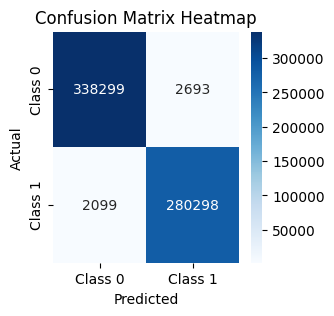

In [253]:
y_pred = default_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.6f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [43]:
catboost_model = CatBoostClassifier(silent=True)
catboost_model.fit(X_train, y_train)

In [44]:
catboost_model.predict_proba(X_test).shape

(311695, 2)

/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Accuracy: 0.988413


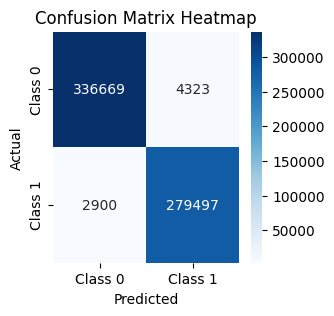

In [256]:
lgb_model = lgb.LGBMClassifier(verbose=-1)
lgb_model.fit(X_train, y_train)

y_pred = lgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.6f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Heatmap')
plt.show()

Accuracy: 0.991363


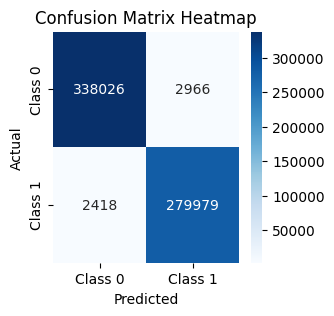

In [255]:
catboost_model = CatBoostClassifier(silent=True)
catboost_model.fit(X_train, y_train)

y_pred = catboost_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.6f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [ ]:
default_model = XGBClassifier(**xgb_params)
# Train the model
default_model.fit(X_train, y_train)

In [259]:
encoded_test_df

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,...,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season,class_1
id,,,,,,,,,,,,,,,,,,,,,
3116945,8.64,0,-1,0,1,-1,-1,0,11.13,17.12,...,-1,0,0,0,1,6,-1,0,0,NaN
3116946,6.90,4,0,5,0,-1,0,2,1.27,10.75,...,-1,1,-1,-1,0,0,-1,0,0,NaN
3116947,2.00,3,4,0,0,-1,0,1,6.18,3.14,...,-1,1,-1,-1,0,0,-1,0,3,NaN
3116948,3.47,0,0,0,0,4,0,1,4.98,8.51,...,-1,0,-1,2,1,2,-1,0,1,NaN
3116949,6.17,0,3,1,0,5,-1,2,6.73,13.70,...,-1,2,-1,1,1,-1,-1,0,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5194904,0.88,0,4,2,0,0,1,0,2.67,1.35,...,-1,5,-1,-1,0,0,-1,0,1,NaN
5194905,3.12,0,1,2,0,1,0,0,2.69,7.38,...,-1,0,-1,-1,0,0,-1,1,0,NaN
5194906,5.73,0,7,4,0,0,-1,0,6.16,9.74,...,-1,2,-1,0,1,2,-1,0,0,NaN


In [298]:
class_mapping = {0 : 'p', 1 : 'e'}

encoded_test_df["class_1"] = pd.Series(default_model.predict(encoded_test_df[X_cols])).to_list()
encoded_test_df["class_2"] = pd.Series(lgb_model.predict(encoded_test_df[X_cols])).to_list()
encoded_test_df["class_3"] = pd.Series(catboost_model.predict(encoded_test_df[X_cols])).to_list()

In [308]:
encoded_test_df["class"] = (encoded_test_df[["class_1", "class_2", "class_3"]].sum(axis=1) > 2).astype(int).apply(lambda x : class_mapping[x])

In [309]:
encoded_test_df

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,...,veil-color,has-ring,ring-type,spore-print-color,habitat,season,class_1,class_2,class_3,class
id,,,,,,,,,,,,,,,,,,,,,
3116945,8.64,0,-1,0,1,-1,-1,0,11.13,17.12,...,0,1,6,-1,0,0,1,1,1,e
3116946,6.90,4,0,5,0,-1,0,2,1.27,10.75,...,-1,0,0,-1,0,0,0,0,0,p
3116947,2.00,3,4,0,0,-1,0,1,6.18,3.14,...,-1,0,0,-1,0,3,0,0,0,p
3116948,3.47,0,0,0,0,4,0,1,4.98,8.51,...,2,1,2,-1,0,1,0,0,0,p
3116949,6.17,0,3,1,0,5,-1,2,6.73,13.70,...,1,1,-1,-1,0,1,1,1,1,e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5194904,0.88,0,4,2,0,0,1,0,2.67,1.35,...,-1,0,0,-1,0,1,0,0,0,p
5194905,3.12,0,1,2,0,1,0,0,2.69,7.38,...,-1,0,0,-1,1,0,0,0,0,p
5194906,5.73,0,7,4,0,0,-1,0,6.16,9.74,...,0,1,2,-1,0,0,0,0,0,p


In [347]:
class_mapping = {0 : 'p', 1 : 'e'}
encoded_test_df["class"] = pd.Series(default_model.predict(encoded_test_df[X_cols])).apply(lambda x : class_mapping[x]).to_list()
encoded_test_df['class'].to_csv("submissions/poisonous_mushrooms/poisonous_mushroom_submission_v8.csv")

In [64]:
# df.isna().sum(axis=1)/df.shape[1]

# Catboost

In [18]:
df.fillna(-1, inplace=True)
test_df.fillna(-1, inplace=True)

In [19]:
df

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,,
0,e,8.80,f,s,u,f,a,c,w,4.51,...,-1,-1,w,-1,-1,f,f,-1,d,a
1,p,4.51,x,h,o,f,a,c,n,4.79,...,-1,y,o,-1,-1,t,z,-1,d,w
2,e,6.94,f,s,b,f,x,c,w,6.85,...,-1,s,n,-1,-1,f,f,-1,l,w
3,e,3.88,f,y,g,f,s,-1,g,4.16,...,-1,-1,w,-1,-1,f,f,-1,d,u
4,e,5.85,x,l,w,f,d,-1,w,3.37,...,-1,-1,w,-1,-1,f,f,-1,g,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116940,e,9.29,f,-1,n,t,-1,-1,w,12.14,...,b,-1,w,u,w,t,g,-1,d,u
3116941,e,10.88,s,-1,w,t,d,c,p,6.65,...,-1,-1,w,-1,-1,f,f,-1,d,u
3116942,p,7.82,x,e,e,f,a,-1,w,9.51,...,-1,-1,y,-1,w,t,z,-1,d,a


In [41]:
X_cols = ['cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season']
y_cols = ["class"]
X_train, X_test, y_train, y_test = train_test_split(df[X_cols], df[y_cols], test_size=0.2, random_state=42)

In [31]:
categorical_features = [col_name for col_name in df if df[col_name].dtype == 'object' and col_name != 'class']

In [24]:
def objective(trial):

    # Define the hyperparameter space
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'random_strength': trial.suggest_int('random_strength', 0, 100),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.5, 2.0),
        'task_type': 'CPU',
        'cat_features' : [col_name for col_name in df if df[col_name].dtype == 'object' and col_name != 'class']
    }

    # Create the CatBoost model with the suggested parameters
    model = cb.CatBoostClassifier(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    
    # # Fit the model on the training data
    # model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0)
    
    # # Predict on the test set
    # y_pred = model.predict(X_test)
    
    # # Calculate accuracy
    # accuracy = accuracy_score(y_test, y_pred)
    
    # Return the accuracy as the objective to maximize
    return scores.mean()

In [36]:
cat_params = {
    'iterations': 1041,
    'learning_rate': 0.08777255350163136,
    'depth': 10,
    'l2_leaf_reg': 0.1259643500248322,
    'bootstrap_type': 'Bayesian',
    'random_strength': 4.276181166674371e-08,
    'bagging_temperature': 0.35995482350907326,
    'od_type': 'Iter',
    'od_wait': 39,
    "verbose": False,
    "allow_writing_files": False,
    "task_type": 'CPU',
    "cat_features": categorical_features
}
model = cb.CatBoostClassifier(**cat_params)
model.fit(X_train, y_train, early_stopping_rounds=50, verbose=10)

In [ ]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.6f}")

# Print classification report for precision, recall, and F1-score
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=6))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [28]:
def print_trial_callback(study, trial):
    print(f"Trial {trial.number}")

In [30]:
# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the study with the objective function
study.optimize(objective, n_trials=2, callbacks=print_trial_callback)

# Print the best hyperparameters and the best score
print("Best hyperparameters: ", study.best_params)
print("Best accuracy: ", study.best_value)

[I 2024-08-18 18:17:03,592] A new study created in memory with name: no-name-caa58d0a-b9c5-45d3-a5dd-33621a743519


0:	learn: 0.6926598	total: 641ms	remaining: 4m 38s
1:	learn: 0.6924810	total: 884ms	remaining: 3m 11s
2:	learn: 0.6919847	total: 1.6s	remaining: 3m 51s
3:	learn: 0.6916154	total: 2.16s	remaining: 3m 52s
4:	learn: 0.6914431	total: 2.27s	remaining: 3m 15s
5:	learn: 0.6910803	total: 2.86s	remaining: 3m 24s
6:	learn: 0.6908018	total: 3.14s	remaining: 3m 11s
7:	learn: 0.6903881	total: 3.68s	remaining: 3m 16s
8:	learn: 0.6900764	total: 4.23s	remaining: 3m 20s
9:	learn: 0.6895220	total: 4.88s	remaining: 3m 27s
10:	learn: 0.6890709	total: 5.43s	remaining: 3m 29s
11:	learn: 0.6886104	total: 5.93s	remaining: 3m 28s
12:	learn: 0.6883064	total: 6.31s	remaining: 3m 24s
13:	learn: 0.6880128	total: 6.8s	remaining: 3m 24s
14:	learn: 0.6876545	total: 7.21s	remaining: 3m 21s
15:	learn: 0.6872052	total: 7.75s	remaining: 3m 22s
16:	learn: 0.6867818	total: 8.38s	remaining: 3m 26s
17:	learn: 0.6862349	total: 8.96s	remaining: 3m 27s
18:	learn: 0.6858786	total: 9.41s	remaining: 3m 26s
19:	learn: 0.6854376	tot

[W 2024-08-18 18:19:46,065] Trial 0 failed with parameters: {'iterations': 435, 'depth': 7, 'learning_rate': 0.0010423984142987218, 'random_strength': 69, 'bagging_temperature': 0.4836207371009318, 'border_count': 47, 'l2_leaf_reg': 0.00814906749982062, 'scale_pos_weight': 1.9188222004022604} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/xs/yw83rqss71nc9hlz48gw8blh0000gn/T/ipykernel_18158/1651761454.py", line 21, in objective
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*

KeyboardInterrupt: 

# Building a multi-layer stacked ensemble model

In [9]:
class MultiLayerStackedEnsembleTabularClassificationModel:

    final_model_prediction_col_name = "final_prediction"

    def __init__(self,
                 base_model_list : List[Any],
                 model_name_list : List[str],
                 final_model,
                 training_features : List[str],
                 target : str,
                 splits=5,
                 random_state=42) -> None:
        self._base_model_list = base_model_list
        self._model_name_list = model_name_list
        self._final_model = final_model
        self._training_features = training_features
        self._target = target
        self._splits = splits
        self._random_state = random_state
        self._fitted = False

    def fit(self, dataframe):
        self._extended_training_features = self._training_features.copy()
        dataframe = self._fit_base_estimators(dataframe.copy())
        X_train, y_train = dataframe[self._extended_training_features], dataframe[self._target]
        self._final_model.fit(X_train, y_train)
        self._fitted = True
        return True
    
    def predict(self, test_data):
        assert self._fitted, "Please fit ensemble model first"
        for i, model in enumerate(self._base_model_list):
            model_name = self._model_name_list[i]
            additional_feature_col_name_1, additional_feature_col_name_2 =  model_name + "_feature_1", model_name + "_feature_2"
            test_data[additional_feature_col_name_1], test_data[additional_feature_col_name_2] = model.predict_proba(test_data[self._training_features]).T
        test_data[self.final_model_prediction_col_name] = self._final_model.predict(test_data[self._extended_training_features])
        return test_data
    
    def _fit_base_estimators(self, dataframe):
        skf = StratifiedKFold(n_splits=self._splits, shuffle=True, random_state=self._random_state)
        X_train, y_train = dataframe[self._training_features], dataframe[self._target]

        for model_name in self._model_name_list: dataframe[model_name + "_feature_1"] = dataframe[model_name + "_feature_2"] = 0.0
        for i, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):
            print(f"Split {i}")
            X_train_data, X_val_data = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_data, _ = y_train.iloc[train_index], y_train.iloc[val_index]

            for j, model in enumerate(self._base_model_list):
                model.fit(X_train_data, 
                          y_train_data)
                model_name = self._model_name_list[j]
                additional_feature_col_name_1, additional_feature_col_name_2 =  model_name + "_feature_1", model_name + "_feature_2"
                y_pred = model.predict_proba(X_val_data)
                dataframe.loc[val_index, additional_feature_col_name_1], dataframe.loc[val_index, additional_feature_col_name_2] = y_pred.T
                if i == 0:
                    self._extended_training_features += [additional_feature_col_name_1, additional_feature_col_name_2]

        for i, model in enumerate(self._base_model_list):
            model.fit(X_train, 
                      y_train)
            self._base_model_list[i] = model
        self.dataframe = dataframe
        return dataframe

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [11]:
bmodel1 = CatBoostClassifier(verbose=False)
bmodel2 = lgb.LGBMClassifier(verbosity=0)
bmodel3 = XGBClassifier()
bmodel4 = MLPClassifier()
bmodel5 = DecisionTreeClassifier()
bmodel6 = RandomForestClassifier()
base_model_list = [bmodel1, bmodel2, bmodel3, bmodel4, bmodel5, bmodel6]
base_model_labels = ["cat_boost", "lightgbm", "xgb", "mlp", "dt", "rf"]

final_model = LogisticRegression()
training_features = ['cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season']
target = "class"
ensemble_model = MultiLayerStackedEnsembleTabularClassificationModel(base_model_list,
                                                                     base_model_labels,
                                                                     final_model,
                                                                     training_features,
                                                                     target,
                                                                     splits=5)

In [12]:
data_manager = KaggleDatasetManager(encoded_df,
                                    training_features,
                                    target,
                                    0.9,
                                    0.1,
                                    0)

(X_train, 
X_valid, 
X_test, 
y_train, 
y_valid, 
y_test) = data_manager.dataset_partition()

In [13]:
from ktools.fitting.model_fitter import BasicModelEvaluation


for base_model in base_model_list:
    print('mcc:', BasicModelEvaluation().evaluate(X_train, y_train, X_test, y_test, base_model, 'mcc'))

mcc: 0.9824817370459216
mcc: 0.9771280255889632
mcc: 0.9823079331878477
mcc: 0.9777510791074399
mcc: 0.9665645137942278
mcc: 0.9836144413684897


In [14]:
train_data = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
test_data = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

In [15]:
ensemble_model.fit(train_data.copy())

Split 0
Split 1
Split 2
Split 3
Split 4


/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


True

In [188]:
# ensemble_model = XGBClassifier(**{"n_estimators" : 300})
# ensemble_model.fit(X_train, y_train)

In [16]:
accuracy = fast_matthews_corr_coeff(y_test, (ensemble_model.predict(test_data)['final_prediction']).to_numpy().squeeze())
print(f"MCC: {accuracy:.6f}")
accuracy = accuracy_score(y_test, (ensemble_model.predict(test_data)['final_prediction']).to_numpy().squeeze())
print(f"Accuracy: {accuracy:.6f}")

MCC: 0.983633
Accuracy: 0.991886


In [17]:
class_mapping = {0 : 'p', 1 : 'e'}
encoded_test_df["class"] = pd.Series(ensemble_model.predict(encoded_test_df[training_features])['final_prediction']).apply(lambda x : class_mapping[x]).to_list()
encoded_test_df['class'].to_csv("submissions/poisonous_mushrooms/poisonous_mushroom_submission_v13.csv")

In [23]:

model = XGBClassifier()
lightgbm_stack_1 = lgb.LGBMClassifier()
catboost_model = CatBoostClassifier(silent=True)

In [28]:
def create_model_predictions(model_list, model_names_list : str, dataset : pd.DataFrame, target : str, splits=5, random_state=42):
    skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=42)
    
    X_train, y_train = dataset.drop(columns=target).copy(), dataset[target].copy()

    for model_name in model_names_list: dataset[model_name + "_feature_1"] = dataset[model_name + "_feature_2"] = 0

    for i, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):
        print(f"Split {i}")
        X_train_data, X_val_data = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_data, _ = y_train.iloc[train_index], y_train.iloc[val_index]

        for model in model_list:
            model.fit(X_train_data, 
                    y_train_data,
                    )

            y_pred = model.predict_proba(X_val_data)
            dataset.loc[val_index, model_name + "_feature_1"], dataset.loc[val_index, model_name + "_feature_2"] = y_pred.T
    
    return dataset

In [21]:
encoded_df = encoded_df.reset_index(drop=True)

In [29]:
new_feature_df = create_model_predictions([model, lightgbm_stack_1, catboost_model], 
                                          ["xgb_base", "lightgbm_base", "catboost_base"], 
                                          encoded_df, 
                                          "class")

Split 0


/var/folders/xs/yw83rqss71nc9hlz48gw8blh0000gn/T/ipykernel_29339/1655018736.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.1616111e-02 5.1544905e-03 6.5057874e-03 ... 7.8618526e-04 2.6737452e-03
 9.9324560e-01]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.loc[val_index, model_name + "_feature_1"], dataset.loc[val_index, model_name + "_feature_2"] = y_pred.T
/var/folders/xs/yw83rqss71nc9hlz48gw8blh0000gn/T/ipykernel_29339/1655018736.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.9883839  0.9948455  0.9934942  ... 0.9992138  0.99732625 0.00675439]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.loc[val_index, model_name + "_feature_1"], dataset.loc[val_index, model_name + "_feature_2"] = y_pred.T


[LightGBM] [Info] Number of positive: 1129239, number of negative: 1364317
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 897
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.452863 -> initscore=-0.189110
[LightGBM] [Info] Start training from score -0.189110
Split 1
[LightGBM] [Info] Number of positive: 1129239, number of negative: 1364317
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.105838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1407
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 22

In [30]:
new_feature_df.columns

Index(['class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season', 'xgb_base_feature', 'xgb_base_feature_1',
       'xgb_base_feature_2', 'lightgbm_base_feature_1',
       'lightgbm_base_feature_2', 'catboost_base_feature_1',
       'catboost_base_feature_2'],
      dtype='object')

In [31]:
features = ['cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season', 'xgb_base_feature_1',
       'xgb_base_feature_2', 'lightgbm_base_feature_1',
       'lightgbm_base_feature_2', 'catboost_base_feature_1',
       'catboost_base_feature_2']

target = ["class"]

In [32]:
data_manager = KaggleDatasetManager(new_feature_df,
                                    features,
                                    target,
                                    0.9,
                                    0.1,
                                    0)

(X_train, 
X_valid, 
X_test, 
y_train, 
y_valid, 
y_test) = data_manager.dataset_partition()

In [36]:
xgb_params = {'max_depth': 34, 
            'learning_rate': 0.009195574997217204, 
            'gamma': 0.947452139226582, 
            'subsample': 0.7048675112537893, 
            'colsample_bytree': 0.36816717431780044, 
            'lambda': 0.003497277552749157, 
            'alpha': 1.8894975902136887e-08, 
            'max_leaves': 478,
            'n_estimators' : 3000}

lightgbm_stack_1 = XGBClassifier(**xgb_params)
lightgbm_stack_1.fit(X_train, y_train)

XGBClassifier(alpha=1.8894975902136887e-08, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.36816717431780044, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.947452139226582,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.003497277552749157,
              learning_rate=0.009195574997217204, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=34, max_leaves=478,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=3000, n_jobs=None, ...)

In [37]:
y_pred = lightgbm_stack_1.predict(X_test)
y_pred.shape

(311695,)

In [38]:
y_pred = lightgbm_stack_1.predict(X_test)
accuracy = fast_matthews_corr_coeff(y_test.to_numpy().squeeze(), y_pred)
print(f"MCC: {accuracy:.6f}")

MCC: 0.983602


In [39]:
X_test

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,...,ring-type,spore-print-color,habitat,season,xgb_base_feature_1,xgb_base_feature_2,lightgbm_base_feature_1,lightgbm_base_feature_2,catboost_base_feature_1,catboost_base_feature_2
1356763,7.82,2,0,7,1,1,-1,4,4.49,13.30,...,0,-1,0,0,0,0,0,0,0.994054,0.005946
2369311,3.20,4,-1,3,0,6,2,7,3.76,17.16,...,0,-1,0,3,0,0,0,0,0.992134,0.007866
1146527,9.36,1,-1,0,1,-1,-1,0,10.12,22.83,...,6,-1,0,0,0,0,0,0,0.000541,0.999459
889383,6.52,2,5,4,1,1,0,0,5.82,8.03,...,0,-1,0,0,0,0,0,0,0.999131,0.000869
416134,3.13,3,0,0,0,-1,-1,1,9.92,6.00,...,-1,0,1,1,0,0,0,0,0.999230,0.000770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1666627,15.93,1,5,0,0,1,0,2,5.53,34.19,...,0,-1,0,0,0,0,0,0,0.998781,0.001219
2077963,9.30,1,-1,3,0,4,0,4,6.53,20.53,...,0,-1,1,0,0,0,0,0,0.000645,0.999355
32013,7.41,2,0,1,0,2,0,2,6.91,15.56,...,0,-1,0,1,0,0,0,0,0.994720,0.005280
1250267,6.77,0,0,4,0,2,-1,0,15.32,7.50,...,0,-1,0,0,0,0,0,0,0.998636,0.001364


In [ ]:
class_mapping = {0 : 'p', 1 : 'e'}
encoded_test_df["class"] = pd.Series(lightgbm_stack_1.predict(encoded_test_df[X_cols])).apply(lambda x : class_mapping[x]).to_list()
encoded_test_df['class'].to_csv("submissions/poisonous_mushrooms/poisonous_mushroom_submission_v8.csv")